# Banking Dive Fraud Visualization Sandbox

Exploratory visuals derived from the high-risk subset of scraped Banking Dive articles. With only a handful of fraud-related observations, each chart emphasizes qualitative insight over statistical certainty.


> Dependencies: `pandas`, `matplotlib`, `seaborn`, `wordcloud`, `scikit-learn`. Install any missing packages with `pip install pandas matplotlib seaborn wordcloud scikit-learn` in your environment before running the notebook.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (10, 5), "axes.titlesize": 14})

DATA_DIR = Path("data")


In [13]:
DATA_PATH = DATA_DIR / "banking_dive_articles_with_fraud.csv"

raw_df = pd.read_csv(DATA_PATH, parse_dates=["publish_date"], infer_datetime_format=True)
fraud_df = raw_df[raw_df["detected_fraud_category"].notna()].copy()
fraud_df["publish_date"] = pd.to_datetime(fraud_df["publish_date"], errors="coerce")

print(f"Total articles: {len(raw_df)} | Fraud-flagged: {len(fraud_df)}")
fraud_df.head()[["title", "publish_date", "detected_fraud_category", "risk_level"]]


Total articles: 200 | Fraud-flagged: 16


C:\Users\gusta\AppData\Local\Temp\ipykernel_6312\824785793.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_df = pd.read_csv(DATA_PATH, parse_dates=["publish_date"], infer_datetime_format=True)


,title,publish_date,detected_fraud_category,risk_level
9,Ex-Truist employee sentenced in ‘complex’ chec...,NaT,"Wire Fraud, Check Fraud",Low
13,"TD illegally targeted, fired Chinese-heritage ...",NaT,Money Laundering,High
34,Ex-Truist employee sentenced in ‘complex’ chec...,NaT,"Wire Fraud, Check Fraud",Low
38,"TD illegally targeted, fired Chinese-heritage ...",NaT,Money Laundering,High
59,Ex-Truist employee sentenced in ‘complex’ chec...,NaT,"Wire Fraud, Check Fraud",Low


In [14]:
cat_counts = fraud_df["detected_fraud_category"].value_counts().sort_values(ascending=False)
risk_counts = fraud_df["risk_level"].value_counts().sort_values(ascending=False)

print("Fraud categories:\n")
display(cat_counts.to_frame("articles"))
print("\nRisk tiers:\n")
display(risk_counts.to_frame("articles"))


Fraud categories:



,articles
detected_fraud_category,
"Wire Fraud, Check Fraud",8
Money Laundering,8



Risk tiers:



,articles
risk_level,
Low,8
High,8


C:\Users\gusta\AppData\Local\Temp\ipykernel_6312\1137350264.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette="Reds", ax=ax)


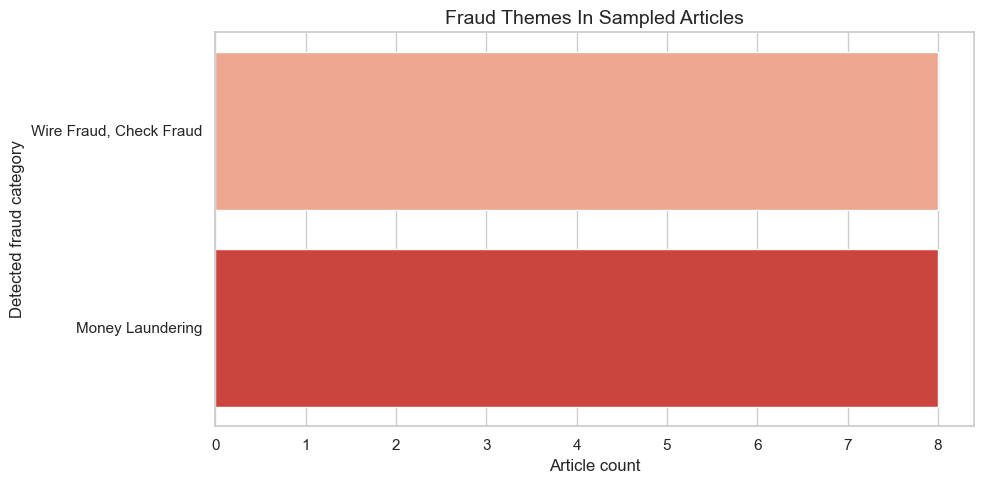

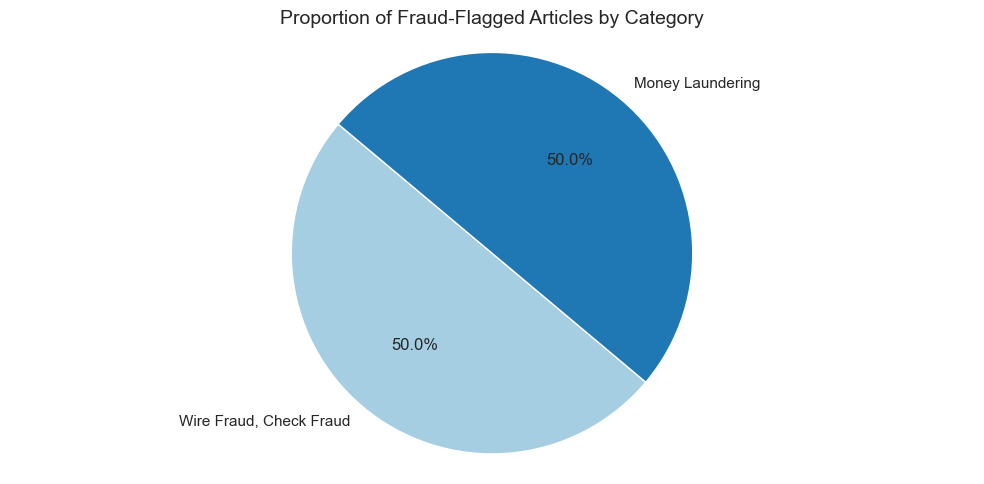

In [15]:
fig, ax = plt.subplots()
sns.barplot(x=cat_counts.values, y=cat_counts.index, palette="Reds", ax=ax)
ax.set_title("Fraud Themes In Sampled Articles")
ax.set_xlabel("Article count")
ax.set_ylabel("Detected fraud category")
plt.tight_layout()
fig, ax = plt.subplots()
ax.pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Paired", n_colors=len(cat_counts)))
ax.set_title("Proportion of Fraud-Flagged Articles by Category")
ax.axis('equal')  # Equal aspect ratio ensures the pie is a circle.
plt.tight_layout()
plt.show()


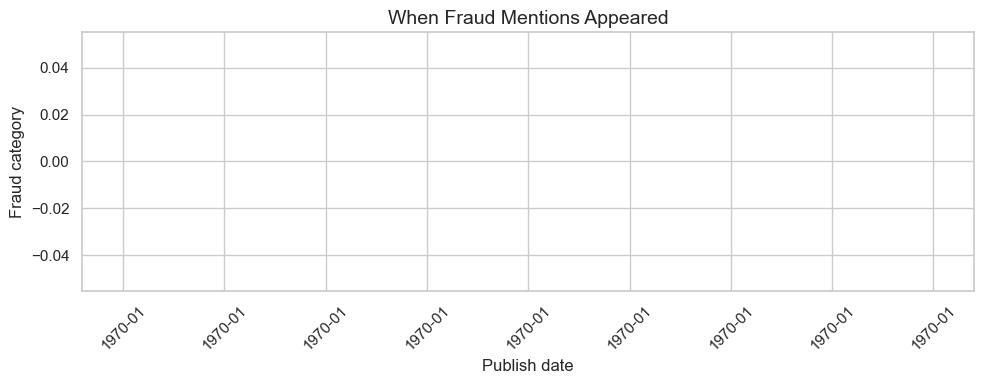

In [16]:
timeline_df = fraud_df.sort_values("publish_date").dropna(subset=["publish_date"])
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(timeline_df["publish_date"], timeline_df["detected_fraud_category"], s=100, c=timeline_df["risk_level"].astype("category").cat.codes, cmap="coolwarm")
for _, row in timeline_df.iterrows():
    ax.text(row["publish_date"], row["detected_fraud_category"], row["risk_level"], fontsize=9, ha="left", va="bottom")
ax.set_title("When Fraud Mentions Appeared")
ax.set_xlabel("Publish date")
ax.set_ylabel("Fraud category")
# Change x-axis to show only year and month, not day
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


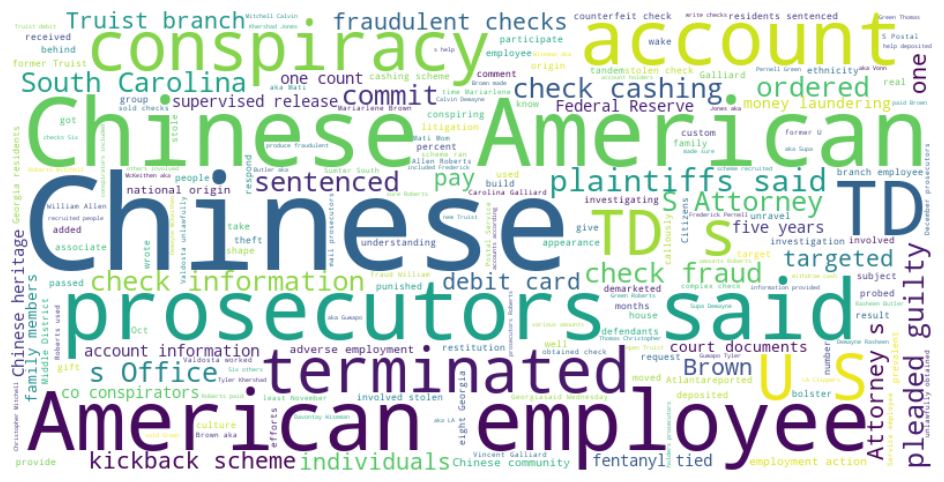

In [17]:
combined_text = " ".join(fraud_df["content"].fillna(""))
stopwords = STOPWORDS.union({"bank", "banks", "financial", "company"})

if combined_text.strip():
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(combined_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
else:
    print("No textual content available for a word cloud.")


C:\Users\gusta\AppData\Local\Temp\ipykernel_6312\3528140982.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phrases.values, y=phrases.index, palette="Blues_r")


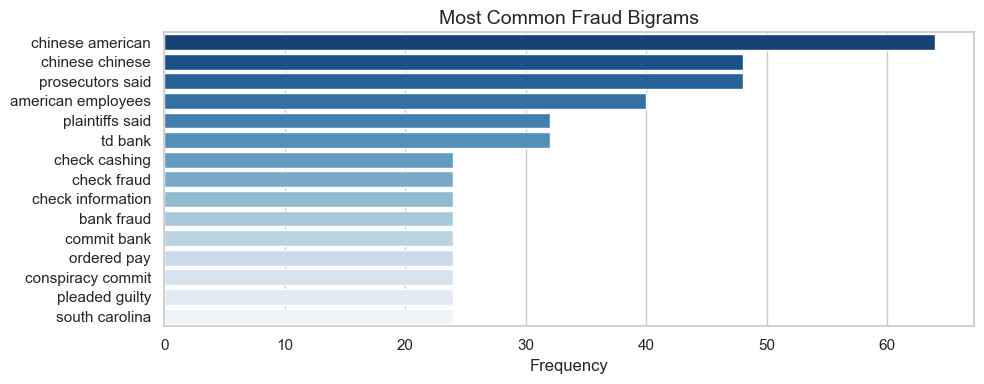

In [18]:
vectorizer = CountVectorizer(stop_words="english", ngram_range=(2, 2), max_features=15)
if fraud_df["content"].notna().any():
    matrix = vectorizer.fit_transform(fraud_df["content"].fillna(""))
    freqs = matrix.sum(axis=0).A1
    phrases = pd.Series(freqs, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=phrases.values, y=phrases.index, palette="Blues_r")
    plt.title("Most Common Fraud Bigrams")
    plt.xlabel("Frequency")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough textual data for bigram analysis.")


## Notes for future iterations
- Because there are only a few fraud hits, treat each chart as a qualitative cue for reporting angles.
- If new articles land, rerun the notebook to quickly refresh the visuals.
- Consider layering external signals (e.g., enforcement data or stock moves) onto the timeline once the dataset grows.
